In [28]:
import matplotlib.pylab as plt
from matplotlib import gridspec

import numpy as np
import warnings,os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [29]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd


In [30]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

tf.config.run_functions_eagerly(True)
# When tf.config.run_functions_eagerly(True) is called, all TensorFlow operations are executed eagerly, meaning they are immediately evaluated and the result is returned. This can be useful for debugging and experimenting with TensorFlow models, but it can also slow down training and inference, particularly on GPUs or TPUs. By default, TensorFlow uses a graph execution mode for improved performance, where operations are compiled into a computational graph and executed in batches.


In [31]:
img_dir = "./dataset/ALL_IDB1/ALL_IDB1/im" 
img_files = os.listdir(img_dir)
labels = [int(img_file.split('_')[-1].split('.')[0]) for img_file in img_files]
df = pd.DataFrame({
    'filename': img_files,
    'label': labels
})
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)


In [32]:
# Define the image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Define the image size
img_size = (224, 224)

# Define the train generator
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    directory=img_dir,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw'
)

# Define the validation generator
val_generator = val_datagen.flow_from_dataframe(
    df_val,
    directory=img_dir,
    x_col="filename",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='raw'
)


Found 86 validated image filenames.
Found 22 validated image filenames.


In [33]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [41]:
# Create the base model of VGG16
vgg16 = VGG16(weights='imagenet',
              include_top=False, 
              input_shape=(224, 224, 3))


In [42]:
# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# Create a new model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [48]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(epsilon=0.01),
    metrics=['accuracy']
              )


In [49]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(df_train) // batch_size,
    epochs=10,
    validation_data=val_generator,)
    # validation_steps=len(df_val) // batch_size)


C:\Users\shubh\AppData\Local\Temp\ipykernel_22428\470146806.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


c:\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 38s 24s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.2570 - val_accuracy: 0.9545
Epoch 2/10
2/2 [==============================] - 39s 25s/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.2757 - val_accuracy: 0.9545
Epoch 3/10
2/2 [==============================] - 35s 21s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 0.9545
Epoch 4/10
2/2 [==============================] - 34s 21s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.3017 - val_accuracy: 0.9545
Epoch 5/10
2/2 [==============================] - 40s 22s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.9545
Epoch 6/10
2/2 [==============================] - 34s 16s/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.3184 - val_accuracy: 0.9545
Epoch 7/10
2/2 [==============================] - 34s 21s/step - loss: 1.1092e-04 - accuracy: 1.0000 - val_loss: 0.3228 - val_accuracy: 0.9545
Epoch 8/10
2/2 [==================

       loss  accuracy  val_loss  val_accuracy
0  2.120240  0.574074  2.151793      0.409091
1  1.137248  0.611111  0.292820      0.954545
2  0.133244  0.953125  0.132812      0.954545
3  0.299667  0.907407  0.144479      0.954545
4  0.091650  0.962963  0.270489      0.954545


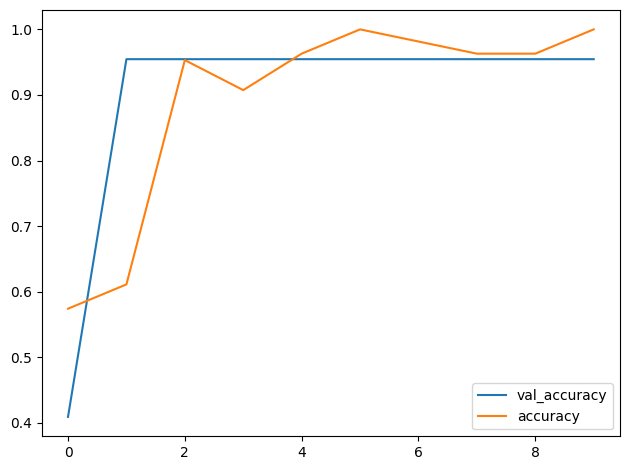

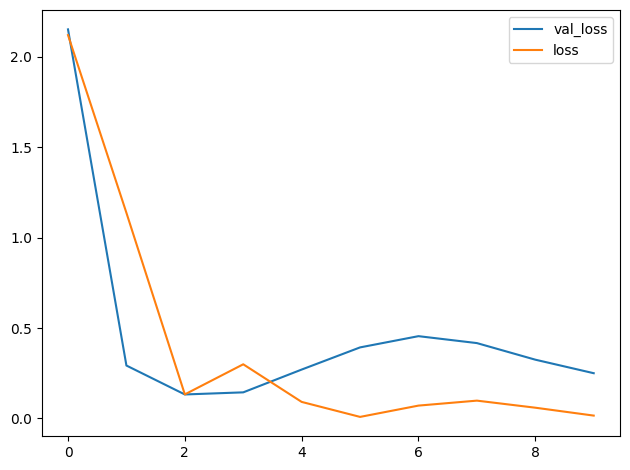

In [47]:
history_frame = pd.DataFrame(history.history)
print(history_frame.head())
history_frame.loc[:, ['val_accuracy', 'accuracy']].plot()
history_frame.loc[:, ['val_loss', 'loss']].plot();